### **Installs:**

In [1]:
!pip cache purge
!pip uninstall -y torch torchtext fastai timm torchvision torchaudio torchdata
!pip install torch==2.3.0 torchtext==0.18.0

Files removed: 20


   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/159.7 MB 10.1 MB/s eta 0:00:16
    --------------------------------------- 2.9/159.7 MB 10.5 MB/s eta 0:00:15
    --------------------------------------- 2.9/159.7 MB 10.5 MB/s eta 0:00:15
    --------------------------------------- 2.9/159.7 MB 10.5 MB/s eta 0:00:15
   - -------------------------------------- 4.2/159.7 MB 4.3 MB/s eta 0:00:37
   - -------------------------------------- 5.5/159.7 MB 4.7 MB/s eta 0:00:34
   - -------------------------------------- 6.6/159.7 MB 4.7 MB/s eta 0:00:33
   - -------------------------------------- 7.3/159.7 MB 4.7 MB/s eta 0:00:33
   - -------------------------------------- 7.9/159.7 MB 4.5 MB/s eta 0:00:34
   -- ------------------------------------- 8.4/159.7 MB 4.2 MB/s eta 0:00:37
   -- ------------------------------------- 8.7/159.7 MB 4.0 MB/s eta 0:00:38
   -- ------------------------------------- 9.2/159.7 MB 3.8 MB/s e

### **Imports:**

In [1]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict,Counter
import re
import numpy as np
import spacy
import pickle
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.feature_extraction.text import CountVectorizer
from torchtext.vocab import GloVe
from sklearn.metrics import accuracy_score, f1_score
nltk.download('stopwords')

C:\Users\chenn\anaconda3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\chenn\anaconda3\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chenn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-

True

### **Exploratory Data Analysis:**

**Classes distribution:** We can see there are comparatively less samples in negative, neutral category compared to positive category. we can use this information for creating better models.

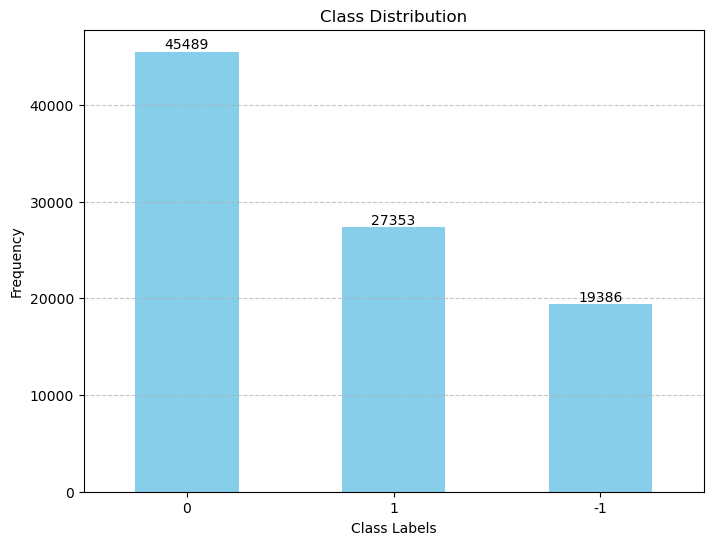

In [5]:
file_path = 'train.csv'
data = pd.read_csv(file_path)
class_distribution = data['gold_label'].value_counts()
plt.figure(figsize=(8, 6))
ax = class_distribution.plot(kind='bar', rot=0, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(class_distribution.index)), labels=class_distribution.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, count in enumerate(class_distribution):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
plt.show()


**Sentence Length Distribution:** Can be used to determine max sentence length during inference and training..

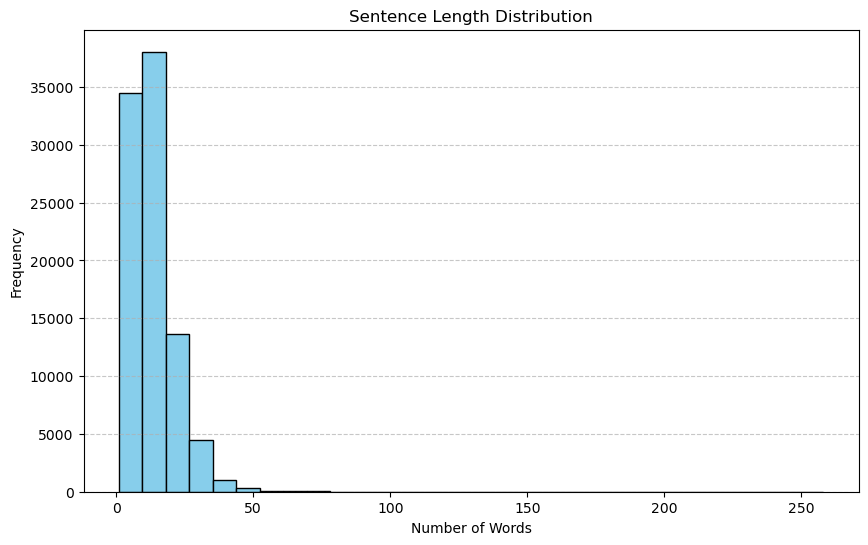

In [8]:
data['sentence_length'] = data['sentence'].str.split().apply(len)
plt.figure(figsize=(10, 6))
plt.hist(data['sentence_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Class-wise Sentence Length Distribution:** In some reserch papers sentence length is included in embedding. But for this task, Based on below graph we can conclude that, There is no relation between sentence length and sentiment.

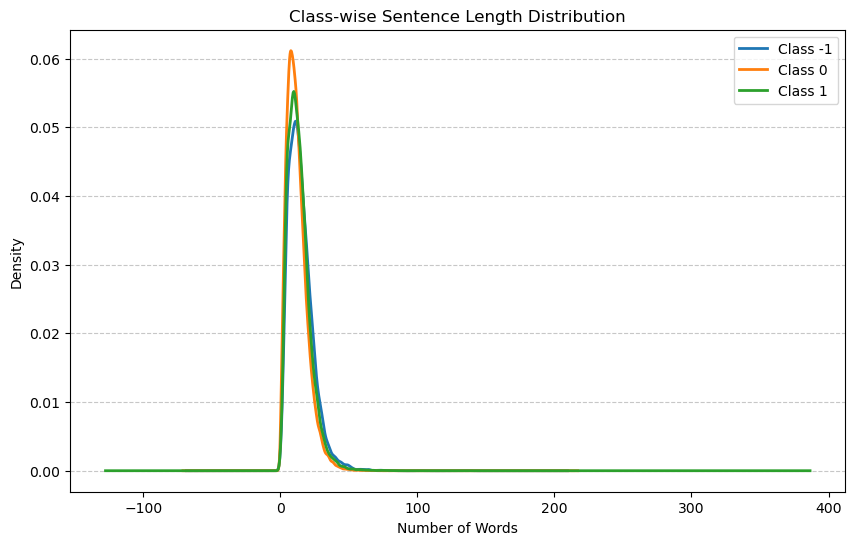

In [10]:
plt.figure(figsize=(10, 6))
for label, group in data.groupby('gold_label'):
    group['sentence_length'].plot(kind='kde', label=f'Class {label}', linewidth=2)

plt.title('Class-wise Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Bigrams:** During tokenization, instead of breaking text into single words, we can use bigrams. Bigrams capture meaningful combinations like "not good" and "very bad," which are particularly useful for sentiment analysis.

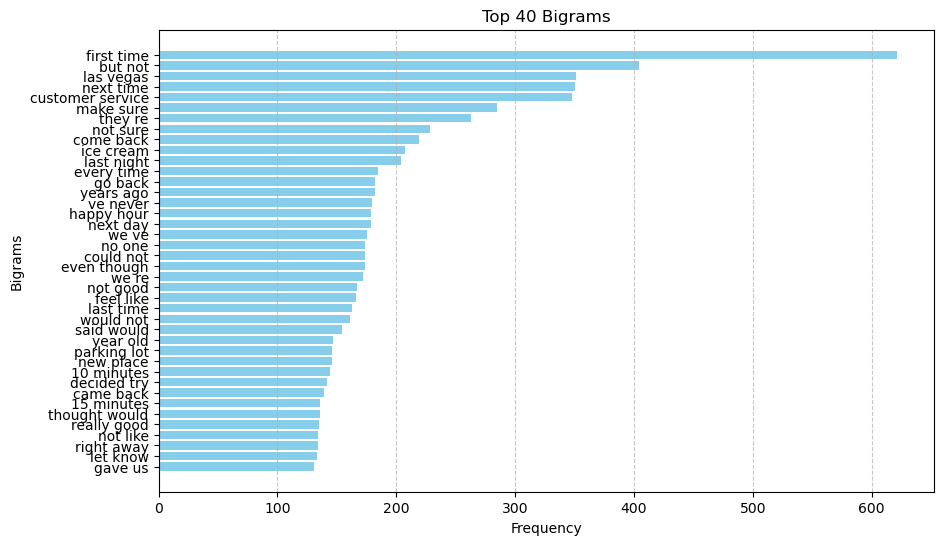

In [13]:
stop_words = set(stopwords.words('english'))
sentiment_words = {'not', 'no', 'never', 'but', 'however', 'yet', 'though'}
filtered_stop_words = stop_words - sentiment_words
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in filtered_stop_words]
    return ' '.join(filtered_words)

data['filtered_sentence'] = data['sentence'].apply(remove_stopwords)
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=40)
bigram_matrix = vectorizer.fit_transform(data['filtered_sentence'].dropna())
bigram_counts = bigram_matrix.sum(axis=0).A1
bigrams = vectorizer.get_feature_names_out()

bigram_df = pd.DataFrame({'bigram': bigrams, 'count': bigram_counts}).sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(bigram_df['bigram'], bigram_df['count'], color='skyblue')
plt.title('Top 40 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### **Custom Word Positivity Score:**

1. This code first reads the dataset, converts sentences to lowercase, and tokenizes them using SpaCy, It ignores stopwords and focuses on words which belongs relevant parts of speech (nouns, verbs, adjectives, and adverbs) which affects sentiment.

2. I tracked how often each word appears in positive, neutral, and negative sentences, while only considering words that occur at least 10 times.

3. Then i calculated score for each word based on its occurrences in positive and negative sentences. These scores are saved to word_positivity_scores.csv for further analysis.

In [ ]:
nlp = spacy.load("en_core_web_sm")
label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}
stopwords = {"a", "the", "and", "is", "in", "to", "for", "of", "on", "it", "this", "that", "with", "as", "at", "by", "an"}
min_frequency = 10
relevant_pos_tags = {"ADJ", "ADV", "VERB", "NOUN"}

word_counts = defaultdict(lambda: {'positive': 0, 'neutral': 0, 'negative': 0})
word_frequencies = defaultdict(int)

df = pd.read_csv("train.csv")

sentences = df['sentence'].str.lower().tolist()
labels = df['gold_label'].tolist()

for doc, label in zip(nlp.pipe(sentences, batch_size=32), labels):
    sentiment = label_map.get(label, 'neutral')
    for token in doc:
        if token.is_alpha and token.pos_ in relevant_pos_tags and token.text not in stopwords:
            word_counts[token.text][sentiment] += 1
            word_frequencies[token.text] += 1

word_scores = {}
for word, counts in word_counts.items():
    if word_frequencies[word] >= min_frequency:
        total_count = counts['positive'] + counts['neutral'] + counts['negative']
        if total_count > 0:
            score = (counts['positive'] - counts['negative']) / total_count
            word_scores[word] = score

word_scores_df = pd.DataFrame(list(word_scores.items()), columns=['word', 'positivity_score'])
word_scores_df = word_scores_df.sort_values(by='positivity_score', ascending=False)
output_path = 'word_positivity_scores.csv'
word_scores_df.to_csv(output_path, index=False)
print(f"Word positivity scores saved to {output_path}")


###**Creating Word Embeddings by combining various Linguistic Features:**

**Reference:**  Sentiment analysis based on improved pre-trained word embeddings(https://www.sciencedirect.com/science/article/abs/pii/S095741741830558X )


**Loading Glove Embedddings:**

In [21]:
from torchtext.vocab import Vectors

# Path to the GloVe file
glove_path = "glove.6B.100d.txt"

# Load GloVe embeddings
glove = Vectors(name="glove.6B.100d.txt", cache='./.vector_cache')  # Use the directory of the file

# Example to check the embedding for a word
print(glove['example'])  # Replace 'example' with any word

100%|██████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:28<00:00, 14007.59it/s]


tensor([-0.1262,  0.6172,  0.2258,  0.3987,  0.1611,  0.1523, -0.1471, -0.2945,
        -0.2735, -0.1375, -0.2090, -0.7344,  0.1414,  0.1505,  0.0918,  0.0186,
         0.2254,  0.1598, -0.1693,  0.4272,  0.0423, -0.3477, -0.1141,  0.1222,
        -0.0250, -0.2080, -0.0673, -0.2956, -0.3081, -0.3290,  0.1906,  0.7714,
        -0.1933, -0.3107,  0.2675,  0.3223,  0.2065,  0.1050,  0.4942, -0.3832,
        -0.1280, -0.0699, -0.1483,  0.0854, -0.1814,  0.1469,  0.6097, -0.2113,
        -0.2915, -0.5277,  0.5951,  0.0174,  0.1534,  0.8192, -0.2064, -2.0378,
        -0.1188, -0.1683,  1.5288,  0.1576, -0.4994,  0.3930,  0.1267, -0.1097,
         1.3671, -0.2101,  0.1568,  0.0064,  0.4384, -0.1876, -0.2909,  0.1862,
         0.0854,  0.1399,  0.4079, -0.1481,  0.2670, -0.1914, -0.6189,  0.0091,
         0.3497, -0.2408, -0.5248, -0.2507, -1.5681,  0.2210,  0.0468, -0.6262,
        -0.0434, -0.4286, -0.0058, -0.2261,  0.0742,  0.0916, -0.4075, -0.0836,
        -0.4841, -1.0718,  0.5283,  0.05

**Loading Custom Created Positivity scores:**

In [23]:
positivity_scores_df = pd.read_csv("word_positivity_scores.csv")
positivity_scores = dict(zip(positivity_scores_df['word'], positivity_scores_df['positivity_score']))


**Embedding Layers for POS and Dependency Tags:** Creating embedding layers for Part-of-Speech (POS) tags and Dependency (DEP) tags, which will be used to represent these linguistic features numerically in word embedding.

In [26]:
pos_tags = ["NOUN", "VERB", "ADJ", "ADV", "PRON", "DET", "ADP", "NUM", "CONJ", "PART", "INTJ", "AUX"]
pos_embedding_layer = nn.Embedding(len(pos_tags), 30)
pos_to_idx = {tag: idx for idx, tag in enumerate(pos_tags)}

dep_tags = list(nlp.get_pipe("parser").labels)
dep_embedding_layer = nn.Embedding(len(dep_tags), 30)
dep_to_idx = {dep: idx for idx, dep in enumerate(dep_tags)}

**Embedding Using Dependency Tree Children:** Extracting the embeddings of the dependent tokens (children in the dependency parse tree) of a given token,then we compute the mean of those embeddings, We can use this information in word embedding of a token.

In [29]:
def get_dependency_contextual_embedding(tokens, index):
    token = tokens[index]
    dependent_tokens = [child for child in token.children]
    context_embeddings = []
    for dep_token in dependent_tokens:
        lower_word = dep_token.text.lower()
        embedding = glove[lower_word] if lower_word in glove.stoi else torch.zeros(100)
        context_embeddings.append(embedding)
    if context_embeddings:
        return torch.mean(torch.stack(context_embeddings), dim=0)
    return torch.zeros(100)

**Creating Final Embedding using Linguistic and Contextual Features:**

1. Created learnable embeddings based on **part-of-speech (POS) tags**, **dependency tags**, **word positivity scores**, **negation**, **punctuation**, and **capitalization**. I used pre-trained **GloVe embeddings** for word vectors and computed **contextual embeddings based on word dependencies**.

2. For each word in a sentence, i combined multiple features (like POS, dependency, contextual embedding, positivity score, and custom features) into a single vector, capturing detailed information about the word's role and sentiment in the sentence.

In [37]:
negation_words = {
    "not", "no", "never", "n't", "cannot", "can't", "won't",
    "didn't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
    "shouldn't", "wouldn't", "couldn't", "mustn't", "mightn't",
    "needn't", "without", "nor", "neither", "nowhere", "none", "nothing", "nobody", "hardly", "scarcely", "barely"
}


def get_token_embedding(token, tokens):
    original_word = token.text
    lower_word = original_word.lower()
    if lower_word in glove.stoi:
        embedding = glove[lower_word]
        if torch.sum(embedding) == 0.0:
            embedding = torch.randn(100)
    else:
        embedding = torch.randn(100)

    # POS Embedding
    pos_index = pos_to_idx.get(token.pos_, len(pos_tags) - 1)
    pos_embedding = pos_embedding_layer(torch.tensor(pos_index)).detach()

    # Positivity Embedding
    positivity_score = 5 * positivity_scores.get(lower_word, 0.0)
    positivity_embedding = torch.tensor([positivity_score], dtype=torch.float32)

    # Dependency Embedding
    dep_index = dep_to_idx.get(token.dep_, len(dep_tags) - 1)
    dep_embedding = dep_embedding_layer(torch.tensor(dep_index)).detach()

    # Negation Feature
    negation = 1.0 if any(ancestor.text.lower() in negation_words for ancestor in token.ancestors) else 0.0
    negation_embedding = torch.tensor([negation], dtype=torch.float32)

    # Contextual Embedding
    contextual_embedding = get_dependency_contextual_embedding(tokens, token.i) if len(tokens) > 1 else torch.zeros(100)

    # Punctuation Feature
    punctuation = 1.0 if any(punct in token.sent.text for punct in {"!", "?"}) else 0.0
    punctuation_embedding = torch.tensor([punctuation], dtype=torch.float32)

    # Capitalization Feature
    capitalization = 1.0 if original_word.isupper() else 0.0
    capitalization_embedding = torch.tensor([capitalization], dtype=torch.float32)

    return torch.cat((
        embedding,
        contextual_embedding,
        pos_embedding,
        dep_embedding,
        positivity_embedding,
        negation_embedding,
        punctuation_embedding,
        capitalization_embedding
    ))

df = pd.read_csv("train.csv")
df['gold_label'] = df['gold_label'].map({-1: 0, 0: 1, 1: 2})


Here i processed the dataset to compute token embeddings for tokens in each sentence, I restricted the number of tokens per sentence to 64.

In [40]:
MAX_TOKENS = 64
from tqdm import tqdm
precomputed_data = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentences"):
    text = row['sentence']
    label = row['gold_label']
    doc = nlp(text)
    limited_tokens = list(doc)[:MAX_TOKENS]
    embeddings = [get_token_embedding(token, doc) for token in limited_tokens]
    precomputed_data.append((torch.stack(embeddings), label))


Processing Sentences: 100%|██████████████████████████████████████████████████████| 92228/92228 [18:07<00:00, 84.82it/s]


### **Model Architecture:**

1. I have used 10% of the training data, keeping it balanced across all classes, to use as validation data using train_test_split.
2. I have created a SentimentDatasetWrapper class to handle easy data access of embeddings and labels during training and validation.
3. BiLSTMWithGlobalMaxPooling model is created with 2 layers of stacked bidirectional LSTM, global max pooling, dropout, and a final linear layer for predictions.
4. Experimented with various combinations of values for hidden size, number of layers, drop out for the model.

**Reason for choosing this architecture:** We know that BiLSTM captures sequential dependencies in the text, considering both past and future context with its bidirectional setup. By adding Global max pooling, It extracts the most prominent features across the sequence, which are crucial for sentiment classification.

**Global max pooling:**

1. BiLSTM output a sequence of hidden states for each time step. This results in a 3D tensor of shape (batch_size, sequence_length, hidden_dim * 2) (because the LSTM is bidirectional).
nn.AdaptiveMaxPool1d(1) reduces the sequence dimension (sequence_length) to a fixed size of 1 by taking the maximum value across all time steps for each feature.

2. It extracts the most significant feature from the sequence for each feature dimension. So that we can then pass it to fully connected layer for final prediction.

In [42]:
#Taking 10% of Training data(equally from all classes) from training data for validation
labels = [item[1] for item in precomputed_data]
train_data, val_data = train_test_split(precomputed_data, test_size=0.1, stratify=labels, random_state=42)

class SentimentDatasetWrapper(Dataset):
    def __init__(self, feature_vectors, target_labels=None):
        self.feature_vectors = feature_vectors #Previously created embeddings
        self.target_labels = target_labels #Corresponding labels

    def __len__(self):
        return len(self.feature_vectors) #Returns the total number of samples in the dataset.

    #This function Fetches a single data sample and its label at the given index.
    def __getitem__(self, index):
        if self.target_labels is not None: #Training
            return self.feature_vectors[index], self.target_labels[index]
        return self.feature_vectors[index] #Testing

class RCAN(nn.Module):  # Recurrent Convolutional Attention Network
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(RCAN, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM layer for sequential processing
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)

        # Convolutional layer for extracting important features
        self.conv = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=hidden_dim, kernel_size=3, padding=1)

        # Fully connected layer for final classification
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Attention weights for importance distribution
        self.attention_weights = nn.Linear(hidden_dim, 1)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout_prob)

    def attention(self, conv_output):
        """
        Attention mechanism to compute importance of each token in sequence.
        """
        # Transpose to shape (batch_size, seq_len, hidden_dim) for compatibility
        conv_output = conv_output.permute(0, 2, 1)

        # Compute attention scores
        scores = torch.tanh(self.attention_weights(conv_output))  # Shape: (batch_size, seq_len, 1)

        # Convert scores to probabilities using softmax
        attention_scores = torch.softmax(scores, dim=1)  # Shape: (batch_size, seq_len, 1)

        # Weighted sum of the convolution output based on attention scores
        context_vector = torch.sum(attention_scores * conv_output, dim=1)  # Shape: (batch_size, hidden_dim)

        return context_vector

    def forward(self, x):
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # LSTM output shape: (batch_size, seq_len, hidden_dim * 2)

        # Reshape for convolutional layer
        lstm_out = lstm_out.permute(0, 2, 1)  # Shape: (batch_size, hidden_dim * 2, seq_len)

        # Apply convolution and activation
        conv_out = torch.relu(self.conv(lstm_out))  # Shape: (batch_size, hidden_dim, seq_len)

        # Compute attention-enhanced feature vector
        attention_output = self.attention(conv_out)  # Shape: (batch_size, hidden_dim)

        # Apply dropout and final classification
        logits = self.fc(self.dropout(attention_output))  # Shape: (batch_size, output_dim)

        return logits


### **Model Training and Validation:**



**Training Pipeline:**

1. Used CrossEntropyLoss as this task is multi-class classification.
2. Used Adam optimizer with learning rate 0.001 and weight decay of 1e−5 for better convergence.
3. Automatically reduces the learning rate if validation loss doesn’t improve for 5 epochs.
4. Limits gradients to a max value (5) to avoid exploding gradients, improving training stability.
5. Stops training if validation F1 score doesn’t improve for patience_threshold epochs (5 here) so that we can prevent overfitting and saves time.
Metrics Used:
6. Used Loss, Accuracy, and Weighted F1 Score Train/Validation Metrics.
7.  Input size: 264 Hidden size: 256, dropout : 0.5 (Tried various values and finalized this)
8. Saved the model at lowest validation loss and used that model for inference.

In [48]:
def train_and_validate(train_data, val_data, model, epochs=40, batch_size=64, patience_threshold=5):
    training_dataset = SentimentDatasetWrapper([x[0] for x in train_data], [x[1] for x in train_data])
    validation_dataset = SentimentDatasetWrapper([x[0] for x in val_data], [x[1] for x in val_data])

    # loader for batches and shuffling train and no shuffle on val
    training_data_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: zip(*batch))
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: zip(*batch))

    #cross entropy for loss and Adam for optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer_instance = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # scheduler for learning rate reduce when loss doesnt go down
    learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_instance, mode='min', patience=5, verbose=True)

    highest_validation_f1 = 0  # to save best val F1
    early_stopping_counter = 0  # for counting bad epochs

    for epoch in range(epochs):
        model.train()  # set model to train mode
        training_losses = []
        ground_truth_train = []  # true labels in train
        predicted_train = []  # predicted labels in train

        # looping over train batches
        for batch_inputs, batch_labels in training_data_loader:
            # padding inputs and moving to device (gpu or cpu)
            padded_inputs = torch.nn.utils.rnn.pad_sequence(batch_inputs, batch_first=True).to(device)
            tensor_labels = torch.tensor(batch_labels).to(device)

            # clearing gradients
            optimizer_instance.zero_grad()

            # forward pass, calculating loss, backward pass
            model_outputs = model(padded_inputs)
            loss_value = loss_function(model_outputs, tensor_labels)
            loss_value.backward()

            # clipping gradients for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer_instance.step()

            # storing train loss and predictions
            training_losses.append(loss_value.item())
            probability_of_classes, predictions = torch.max(model_outputs, 1)  # max gives best class
            ground_truth_train.extend(tensor_labels.cpu().numpy())
            predicted_train.extend(predictions.cpu().numpy())

        # calculate train metrics
        training_accuracy = accuracy_score(ground_truth_train, predicted_train) * 100
        training_f1_score = f1_score(ground_truth_train, predicted_train, average='weighted') * 100
        average_training_loss = np.mean(training_losses)

        model.eval()  # set model to eval mode for validation
        validation_losses = []  # store all val loss
        ground_truth_val = []  # true labels in val
        predicted_val = []  # predicted labels in val

        with torch.no_grad():  # no grad for validation
            for batch_inputs, batch_labels in validation_data_loader:
                # pad inputs and move to device
                padded_inputs = torch.nn.utils.rnn.pad_sequence(batch_inputs, batch_first=True).to(device)
                tensor_labels = torch.tensor(batch_labels).to(device)

                # forward pass and calculate val loss
                model_outputs = model(padded_inputs)
                loss_value = loss_function(model_outputs, tensor_labels)
                validation_losses.append(loss_value.item())
                _, predictions = torch.max(model_outputs, 1)
                ground_truth_val.extend(tensor_labels.cpu().numpy())
                predicted_val.extend(predictions.cpu().numpy())

        # calculate val metrics
        average_validation_loss = np.mean(validation_losses)
        validation_accuracy = accuracy_score(ground_truth_val, predicted_val) * 100
        validation_f1_score = f1_score(ground_truth_val, predicted_val, average='weighted') * 100

        # update learning rate scheduler
        learning_rate_scheduler.step(average_validation_loss)

        # print train and val stats
        print(f"Epoch {epoch + 1} - "
              f"Train Loss: {average_training_loss:.4f}, Train Accuracy: {training_accuracy:.2f}%, Train F1: {training_f1_score:.2f}%, "
              f"Val Loss: {average_validation_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%, Val F1: {validation_f1_score:.2f}%")

        # check if val F1 improves
        if validation_f1_score > highest_validation_f1:
            highest_validation_f1 = validation_f1_score
            early_stopping_counter = 0  # reset early stopping
            torch.save(model.state_dict(), 'best_model_state.pt')  # save best model
        else:
            early_stopping_counter += 1  # increment counter
            if early_stopping_counter >= patience_threshold:  # stop if patience crossed
                print("Early stopping triggered.")
                break

    # load best model state
    model.load_state_dict(torch.load('best_model_state.pt'))
    print(f"Best Validation F1 Score: {highest_validation_f1:.2f}%")

**Initializing and training the BiLSTM model:**


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RCAN(
    input_dim=264,
    hidden_dim=128,
    output_dim=3,
    dropout_prob=0.5
).to(device)

# call train and validate function
train_and_validate(train_data, val_data, model, epochs=40, batch_size=32, patience_threshold=5)


C:\Users\chenn\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1 - Train Loss: 0.7486, Train Accuracy: 68.10%, Train F1: 67.11%, Val Loss: 0.6950, Val Accuracy: 70.32%, Val F1: 70.00%
Epoch 2 - Train Loss: 0.6782, Train Accuracy: 71.51%, Train F1: 70.86%, Val Loss: 0.6811, Val Accuracy: 71.19%, Val F1: 71.07%
Epoch 3 - Train Loss: 0.6401, Train Accuracy: 73.42%, Train F1: 72.90%, Val Loss: 0.6603, Val Accuracy: 72.71%, Val F1: 72.27%
Epoch 4 - Train Loss: 0.6050, Train Accuracy: 74.98%, Train F1: 74.56%, Val Loss: 0.6565, Val Accuracy: 72.51%, Val F1: 71.82%
Epoch 5 - Train Loss: 0.5689, Train Accuracy: 76.61%, Train F1: 76.26%, Val Loss: 0.6784, Val Accuracy: 71.81%, Val F1: 70.63%


KeyboardInterrupt: 

### **Predictions on Test Dataset:**

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm

def generate_predictions(test_file_path, model_path, output_file_path, nlp, get_token_embedding,
    MAX_TOKENS, SentimentDatasetWrapper, model, device):
    # Read test data
    test_data = pd.read_csv(test_file_path)
    precomputed_test_embeddings = []

    # Precompute embeddings for the test dataset
    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        sentence = row['sentence']
        doc_representation = nlp(sentence)
        token_limited_doc = list(doc_representation)[:MAX_TOKENS]
        token_embeddings = [get_token_embedding(token, doc_representation) for token in token_limited_doc]
        precomputed_test_embeddings.append(torch.stack(token_embeddings))

    # Wrap test data into a dataset and create a DataLoader
    test_dataset = SentimentDatasetWrapper(precomputed_test_embeddings)
    test_data_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=lambda batch: batch
    )

    # Load trained model and set to evaluation mode
    model.load_state_dict(torch.load(model_path))
    model.eval()
    predicted_labels = []

    # Perform inference
    with torch.no_grad():
        for batch_embeddings in tqdm(test_data_loader):
            padded_batch_embeddings = torch.nn.utils.rnn.pad_sequence(
                batch_embeddings,
                batch_first=True
            ).to(device)
            model_outputs = model(padded_batch_embeddings)
            _, batch_predictions = torch.max(model_outputs, 1)
            predicted_labels.extend(batch_predictions.cpu().numpy())

    # Adjust predictions to match desired output format
    final_predictions = [label - 1 for label in predicted_labels]

    # Write predictions to a file
    with open(output_file_path, 'w') as output_file:
        for prediction in final_predictions:
            output_file.write(f"{prediction}\n")

    print(f"Predictions saved to {output_file_path}")


generate_predictions(test_file_path="test.csv", model_path="best_model_state.pt",output_file_path="answer.txt",
    nlp=nlp,get_token_embedding=get_token_embedding,MAX_TOKENS=MAX_TOKENS,SentimentDatasetWrapper=SentimentDatasetWrapper,model=model,device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))


  4%|██▊                                                                            | 181/5110 [00:02<01:07, 73.53it/s]